FRE-6971 Final Part 2 5/14/2018 by Yidi Wang Hope you enjoy my final project. :)

Problem 2

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import statsmodels.api as sm
import statsmodels.tsa.stattools as ts
import scipy.optimize as opt
import math as math
%matplotlib inline

E:\Python\lib\site-packages\statsmodels\compat\pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


In [2]:
# 2.1 Estimation & residuals.
# I choose the 1-Factor Vasicek Model.
# dr(t) = (mu-k*r(t))dt + vol*dW(t)
def mean_r(r0, p, t, dist='Q'):
    mu,k,vol = p
    m = r0 * np.exp(-k*t) + mu / k * (1 - np.exp(-k * t))
    if (dist == 'F'):
        m -= (vol ** 2) * pow(t,2)
    return m
def A(p, tau):
    mu,k,vol = p
    return (mu/k - vol**2/(2*pow(k,2))) * (B(tau,k)-tau) - vol**2/(4*k)*B(tau,k)
def B(tau, k):
    return (1-np.exp(-k*tau))/k
def zero(t0, T, r_t0):
    tau = T - t0
    return np.exp(A(tau) - B(tau)*r_t0)

In [3]:
def fwd_rate(r0, p, t_fix, T0, T1, dist = 'Q', acrual = 0.25):
    mu, k, vol = p
    A_diff = A(p, T0-t_fix) - A(p, T1-t_fix)
    B_diff = B(T0-t_fix, k) - B(T1-t_fix, k)
    m = A_diff - B_diff * mean_r(r0,p,t_fix,dist)
    v = vol ** 2 * t_fix * pow(B_diff, 2)
    e = np.exp(m + v/2)
    return 1/acrual * (e-1)

In [4]:
# Use the EuroDollar Futures Rate to fit the model.
df = pd.read_csv('D:/FIproject/Constant_Maturity_ED.csv')
df = df.set_index(['Date'])
df.index = pd.to_datetime(df.index)
sample_A = df[(df.index >= '2011-1-1') & (df.index <= '2015-1-1')]
df_rates = df[df.index == '2011-1-3']

In [5]:
df_rates

,ED1,ED2,ED3,ED4,ED5,ED6,ED7,ED8,ED9,ED10,ED11,ED12,ED13,ED14,ED15,ED16,ED17,ED18,ED19,ED20
Date,,,,,,,,,,,,,,,,,,,,
2011-01-03,0.379928,0.455735,0.569463,0.747582,0.969288,1.238364,1.515791,1.802466,2.079458,2.36615,2.632994,2.9,3.127519,3.355027,3.572753,3.786207,3.965677,4.129543,4.278931,4.417864


In [6]:
x = range(1,21)
term = [xx/4. for xx in x]
y = df_rates.ix[0,:]
def error(p):
    yy = [fwd_rate(r0,p,t,t,t+0.25,'Q',acrual=0.25)*100 for t in term]
    return yy - y

E:\Python\lib\site-packages\ipykernel_launcher.py:3: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated
  This is separate from the ipykernel package so we can avoid doing imports until


In [7]:
r0 = 0.01
p0 = (0.01, 0.01, 0.01)
para = opt.leastsq(error, p0)[0]
print('The parameters we get from the calibration: \n')
print('mu:      %.6f'%para[0])
print('k:       %.6f'%para[1])
print('sigma:  %.6f'%para[2])
print('1-Factor Vasicek Model: dr(t)=(%.6f-(%.6f*r(t))dt + %.6f*dW(t)'%(para[0],para[1],para[2]))

The parameters we get from the calibration: 

mu:      0.006053
k:       0.001314
sigma:  -0.000005
1-Factor Vasicek Model: dr(t)=(0.006053-(0.001314*r(t))dt + -0.000005*dW(t)


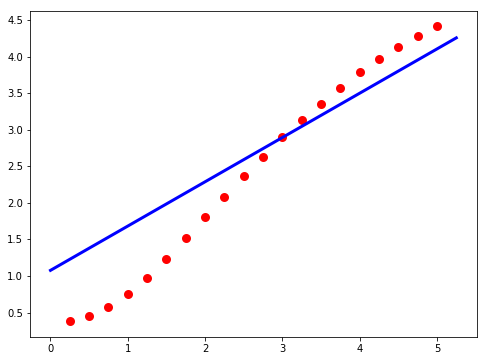

In [8]:
plt.figure(figsize = (8,6))
plt.scatter(term, y, color = 'red', label = 'sample', linewidth = 3)
xx = np.linspace(0, 21/4., 1000)
yyy = [fwd_rate(r0, para, t, t, t+0.25, 'Q', acrual = 0.25)*100 for t in xx]
plt.plot(xx, yyy, color = 'blue', label = 'fit', linewidth = 3)
plt.show()

In [9]:
# 2. On each iteration you should inspect if the problem becomes collinear.
# Inspect the Jacobian matrix.
para_j = opt.least_squares(error, p0).jac
print('Jacobian Matrixi is: \n',para_j)

Jacobian Matrixi is: 
 [[  3.76145422e+01  -2.13265419e-02  -5.64432144e-01]
 [  6.27139270e+01  -3.47709656e-01  -5.64652681e-01]
 [  8.78317356e+01  -7.12043047e-01  -5.64873219e-01]
 [  1.12967974e+02  -1.11443996e+00  -5.65093756e-01]
 [  1.38122648e+02  -1.55488253e+00  -5.65314293e-01]
 [  1.63295770e+02  -2.03347206e+00  -5.65528870e-01]
 [  1.88487351e+02  -2.55025029e+00  -5.65749407e-01]
 [  2.13697398e+02  -3.10526490e+00  -5.65969944e-01]
 [  2.38925922e+02  -3.69843245e+00  -5.66190481e-01]
 [  2.64172935e+02  -4.32998538e+00  -5.66411018e-01]
 [  2.89438438e+02  -4.99984026e+00  -5.66631556e-01]
 [  3.14722449e+02  -5.70805073e+00  -5.66846132e-01]
 [  3.40024978e+02  -6.45464063e+00  -5.67072630e-01]
 [  3.65346032e+02  -7.23966956e+00  -5.67293167e-01]
 [  3.90685618e+02  -8.06324482e+00  -5.67513704e-01]
 [  4.16043746e+02  -8.92546177e+00  -5.67728281e-01]
 [  4.41420436e+02  -9.82611775e+00  -5.67954779e-01]
 [  4.66815686e+02  -1.07654512e+01  -5.68169355e-01]
 [  4

In [10]:
print('Correlation matrix of the Jacobian is :\n', pd.DataFrame(para_j).corr())

Correlation matrix of the Jacobian is :
           0         1         2
0  1.000000 -0.989639 -0.999998
1 -0.989639  1.000000  0.989477
2 -0.999998  0.989477  1.000000


In [11]:
# According to the above result that it really shows collinearity.
# 3. Use the PCA rank reduction to work with this problem.
coef = pd.DataFrame(para_j)
C = coef.cov()
evals, evecs = np.linalg.eig(C)
indices = np.argsort(evals)
indices = indices[::-1]
evals = evals[indices]
evecs = evecs[:,indices]
print('eigenvalue: \n')
print(evals)

eigenvalue: 

[  2.23580839e+04   3.30900404e-01   5.44109517e-12]


In [12]:
print('PCA parameters: \n')
print(evecs)

PCA parameters: 

[[  9.99648111e-01  -2.65264763e-02   8.77400314e-06]
 [ -2.65264763e-02  -9.99648111e-01   2.51481259e-06]
 [ -8.70420655e-06   2.74667104e-06   1.00000000e+00]]


In [13]:
# Use mu, k and vol to substitute the PCA_1.
print('PCA_1: %.6f*mu + %.6f*k + %.6f*vol'%(evecs[0,0],evecs[1,0],evecs[2,0]))

PCA_1: 0.999648*mu + -0.026526*k + -0.000009*vol


In [14]:
# 4. Generate time series of the residuals (input futures date - model futures rate) 
#    for all 20 interploated futrues and study in-sample time series properties of the residuals.
#    Stationary, mean-reversion(half-life), volatitlity and shape of the distribution.

In [15]:
# Calculate the overall residuals.
residual_list = []
for i in range(len(sample_A.index)):
    y = sample_A.iloc[i,:]
    yy = [fwd_rate(r0,para,t,t,t+0.25,'Q',acrual=0.25)*100 for t in term]
    residual = y - yy 
    residual_list.append(residual)

In [16]:
# Define a function to generate the time-series residual from the data.
def generate_ts(residual,n):
    list_ED = []
    for i in range(992):
        ED = residual[i].iloc[n]
        list_ED.append(ED)
    return pd.DataFrame(list_ED,index=sample_A.index)

In [17]:
ED1_residual = generate_ts(residual_list,0)[0]

In [18]:
results = ts.adfuller(ED1_residual)
# Define the function to calculate the properties of the residuals:
# including stationarity, half-life and volatility.
def AR_1(data):
    data_lag = data.shift(1).dropna()
    df = data.drop(data.index[0]).dropna()
    X = data_lag.as_matrix()
    X_I = sm.add_constant(X)
    Y = df.as_matrix()
    l1 = sm.OLS(Y, X_I).fit()
    return l1
def HF(b):
    hf = math.log(0.5)/math.log(b)
    return hf

In [19]:
# Define the function to show the properties.
def output(ED_residual):
    adf = ts.adfuller(ED_residual)
    adf_p = adf[1]
    hf = HF(AR_1(ED_residual).params[1])
    ED_std = ED_residual.std()
    return [adf_p,hf,ED_std]

In [20]:
ED1_residual_ = output(ED1_residual)

In [21]:
# Hihglight the results for 2y, 3y, 4y, 5y futures.
ED8_residual = generate_ts(residual_list,7)[0]
ED12_residual = generate_ts(residual_list,11)[0]
ED16_residual = generate_ts(residual_list,15)[0]
ED20_residual = generate_ts(residual_list,19)[0]

In [22]:
def print_p(ED_residual):
    list_ = output(ED_residual)
    print('The ADF test p-value is: %.6f'%list_[0])
    print('The half-life is: %.6f'%list_[1])
    print('The standard error is: %.6f'%list_[2])

In [23]:
# For 2 year.
print('The outcome of 2y Reiduals: \n')
print_p(ED8_residual)

The outcome of 2y Reiduals: 

The ADF test p-value is: 0.442383
The half-life is: 54.117579
The standard error is: 0.497832


In [24]:
# For 3 year.
print('The outcome of 3y Reiduals: \n')
print_p(ED12_residual)

The outcome of 3y Reiduals: 

The ADF test p-value is: 0.411555
The half-life is: 73.711567
The standard error is: 0.717492


In [25]:
# For 4 year.
print('The outcome of 4y Reiduals: \n')
print_p(ED16_residual)

The outcome of 4y Reiduals: 

The ADF test p-value is: 0.400511
The half-life is: 89.003734
The standard error is: 0.795682


In [26]:
# For 5 year.
print('The outcome of 5y Reiduals: \n')
print_p(ED20_residual)

The outcome of 5y Reiduals: 

The ADF test p-value is: 0.367011
The half-life is: 52.890007
The standard error is: 0.815999


In [27]:
# 2.2 Cointegrated pairs of residuals & signal analysis.
# 1. Construct cointegrated pairs of the residuals, using the combinations and weights determined in 1.1.
C = sample_A.cov()
evals, evecs = np.linalg.eig(C)
indices = np.argsort(evals)
indices = indices[::-1]
evecs = evecs[:,indices]
evals = evals[indices]
w = [evecs[7,0]/evecs[11,0], evecs[11,0]/evecs[15,0], evecs[15,0]/evecs[19,0],
     evecs[7,0]/evecs[15,0], evecs[11,0]/evecs[19,0]]
pair_1 = ED8_residual - w[0] * ED12_residual
pair_2 = ED12_residual - w[1] * ED16_residual
pair_3 = ED16_residual - w[2] * ED20_residual
pair_4 = ED8_residual - w[3] * ED16_residual
pair_5 = ED12_residual - w[4] * ED20_residual

In [28]:
fit_1 = AR_1(pair_1).params
fit_2 = AR_1(pair_2).params
fit_3 = AR_1(pair_3).params
fit_4 = AR_1(pair_4).params
fit_5 = AR_1(pair_5).params
print('AR(1) model is: \n')
print('AR(1) model of pair 1 is: Yt = %f + %f * Yt-1'%(fit_1[0], fit_1[1]))
print('AR(1) model of pair 2 is: Yt = %f + %f * Yt-1'%(fit_2[0], fit_2[1]))
print('AR(1) model of pair 3 is: Yt = %f + %f * Yt-1'%(fit_3[0], fit_3[1]))
print('AR(1) model of pair 4 is: Yt = %f + %f * Yt-1'%(fit_4[0], fit_4[1]))
print('AR(1) model of pair 5 is: Yt = %f + %f * Yt-1'%(fit_5[0], fit_5[1]))

AR(1) model is: 

AR(1) model of pair 1 is: Yt = -0.007477 + 0.984395 * Yt-1
AR(1) model of pair 2 is: Yt = -0.001692 + 0.989006 * Yt-1
AR(1) model of pair 3 is: Yt = 0.010644 + 0.725586 * Yt-1
AR(1) model of pair 4 is: Yt = -0.006702 + 0.988282 * Yt-1
AR(1) model of pair 5 is: Yt = -0.010772 + 0.929906 * Yt-1


In [29]:
def EMA_AR_1(lambda_, data):
    M = data.dropna()
    for i in range(1,len(M)):
        M[i] = (1 - lambda_)*M[i-1] + lambda_ * data[i]
    data_EMA = data - M
    # Use this model to fit the AR(1) model.
    return AR_1(data_EMA), data_EMA

In [30]:
def error(lambda_, data):
    EMA_fit = EMA_AR_1(lambda_, data)[0].params
    hf = HF(EMA_fit[1])
    error = abs(hf - 5)
    return error

In [31]:
initial_lambda = 0.1
lambda_1 = opt.leastsq(error, initial_lambda, args = pair_1)[0]
lambda_2 = opt.leastsq(error, initial_lambda, args = pair_2)[0]
lambda_3 = opt.leastsq(error, initial_lambda, args = pair_3)[0]
lambda_4 = opt.leastsq(error, initial_lambda, args = pair_4)[0]
lambda_5 = opt.leastsq(error, initial_lambda, args = pair_5)[0]

E:\Python\lib\site-packages\ipykernel_launcher.py:4: RuntimeWarning: overflow encountered in multiply
  after removing the cwd from sys.path.
E:\Python\lib\site-packages\numpy\linalg\linalg.py:1574: RuntimeWarning: invalid value encountered in greater
  return (S > tol).sum(axis=-1)


In [32]:
print('Opitimized lambda for each EMA paris: \n')
print('lambda_1 for Half-Life ~5days of EMA_1 = %f'%(lambda_1))
print('lambda_2 for Half-Life ~5days of EMA_2 = %f'%(lambda_2))
print('lambda_3 for Half-Life ~5days of EMA_3 = %f'%(lambda_3))
print('lambda_4 for Half-Life ~5days of EMA_4 = %f'%(lambda_4))
print('lambda_5 for Half-Life ~5days of EMA_5 = %f'%(lambda_5))

Opitimized lambda for each EMA paris: 

lambda_1 for Half-Life ~5days of EMA_1 = 0.049055
lambda_2 for Half-Life ~5days of EMA_2 = 0.053806
lambda_3 for Half-Life ~5days of EMA_3 = -0.005792
lambda_4 for Half-Life ~5days of EMA_4 = 0.054425
lambda_5 for Half-Life ~5days of EMA_5 = 0.008287


In [33]:
fit_EMA1 = EMA_AR_1(lambda_1,pair_1)[0].params
fit_EMA2 = EMA_AR_1(lambda_2,pair_2)[0].params
fit_EMA3 = EMA_AR_1(lambda_3,pair_3)[0].params
fit_EMA4 = EMA_AR_1(lambda_4,pair_4)[0].params
fit_EMA5 = EMA_AR_1(lambda_5,pair_5)[0].params